# Reading the data
Keeping only the votes per party. The previous columns are the settlement names, etc <br>
Dropping booths with zero votes

In [1]:
import numpy as np
import pandas as pd


df = pd.read_csv('../input/results_by_booth_2015 - english - v3.csv', encoding='iso-8859-1')
votes=df.select_dtypes(include=[np.number])
votes=votes.drop(votes.columns[range(0,6)],axis=1) 

party_titles=df.select_dtypes(include=[np.number]).columns.tolist()
party_titles=party_titles[6:]

votes=(votes[(votes.sum(axis=1)>0)])

N=votes.shape[0]
M=votes.shape[1]

# Partitioning the booths into different clusters using K-Means, and plotting them on a 2-D plot using PCA
Inspired by [This analysis of the 2013 elections (Hebrew)](http://https://sadnadearaa.blogspot.co.il/2013/01/blog-post_24.html) <br>
Note that we analyze the partition of votes per booth, to account for booths with different sizes <br>
The top 5 parties is each cluster is shown. <br>
K=4 was chosen because it is possible to see all clusters clearly in a 2-D plot.

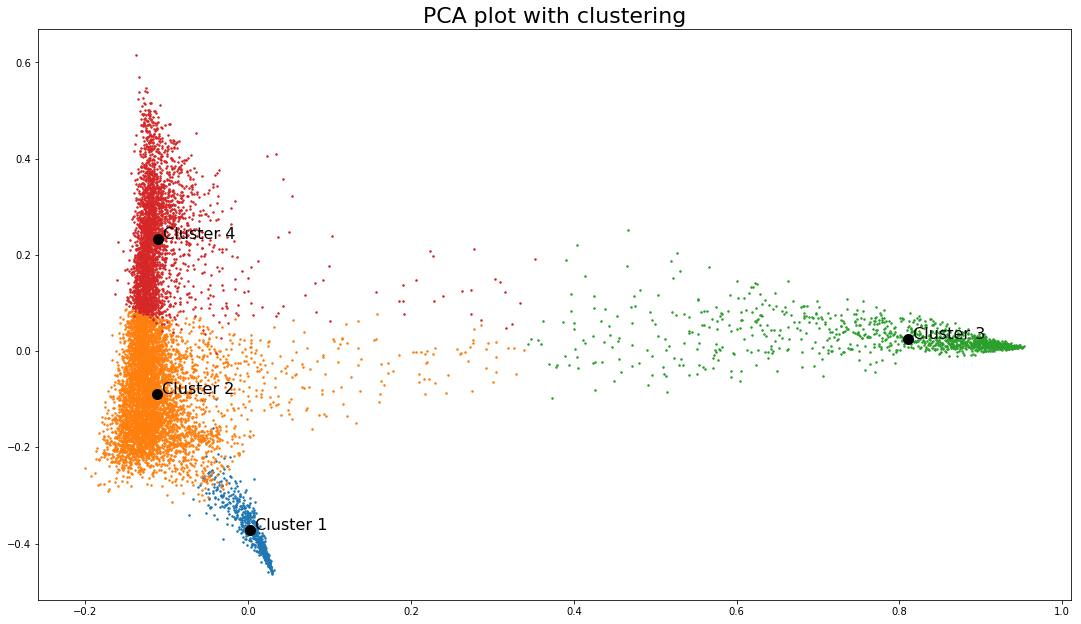

Cluster 1: United Torah Judaism - 0.58, Shas - 0.23, Yachad - 0.08, Likud - 0.05, The Jewish Home - 0.03, 
Cluster 2: Likud - 0.34, Zionist Union - 0.12, Kulanu - 0.1, The Jewish Home - 0.09, Yisrael Beiteinu - 0.09, 
Cluster 3: Joint List - 0.86, Zionist Union - 0.04, Meretz - 0.03, Likud - 0.02, Yisrael Beiteinu - 0.01, 
Cluster 4: Zionist Union - 0.4, Likud - 0.16, Yesh Atid - 0.15, Meretz - 0.09, Kulanu - 0.08, 


In [2]:
import sklearn
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
pca=sklearnPCA(n_components=2)

relative_votes=votes.div(votes.sum(axis=1), axis=0) 
X=pca.fit_transform(relative_votes)

K=4; 
kmeanModel = KMeans(n_clusters=K, max_iter=100).fit(relative_votes)
kmeanModel.fit(relative_votes)

for k in range(0,K):
    plt.plot(X[kmeanModel.labels_==k,0],X[kmeanModel.labels_==k,1],'.',markersize=3)
    current_cluster_x=np.mean(X[kmeanModel.labels_==k,0])
    current_cluster_y=np.mean(X[kmeanModel.labels_==k,1])
    plt.plot(current_cluster_x,current_cluster_y,'ok',markersize=10)
    plt.text(current_cluster_x,current_cluster_y,r' Cluster '+str(k+1), fontsize=16)
plt.title('PCA plot with clustering', fontsize=22)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

cluster=[1]*K
for k in range(0,K):
    cluster[k]=tuple(zip(kmeanModel.cluster_centers_[k],party_titles))
    cluster[k]=sorted(cluster[k],reverse=True)
    print ('Cluster '+str(k+1)+':', end=' ')
    for i in range(0,5):
        print(cluster[k][i][1]+" - "+str(round(100*cluster[k][i][0])/100), end=', ')
    print()
    

## Evidently, the Joint List (Arab party) dominated booths are clearly separated from booths ruled by other major parties.
## Those are separeted clearly into clusters dominated by the Zionist Union, Likud, and United Torah Judaism (from top to bottom), with the first two clusters showing some significant mixing.

# Showing the correlation plot between parties. 
## Each node corresponds to a party, and an edge between parties corresponds to positive correlation between the fraction of votes for those two parties.
No threshold is taken for the correlation (at this phase). <br> 
Parties are partitioned into communities, maximizing connections inside a community and minimizing connections between nodes from different communities.

/opt/conda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/opt/conda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/opt/conda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):


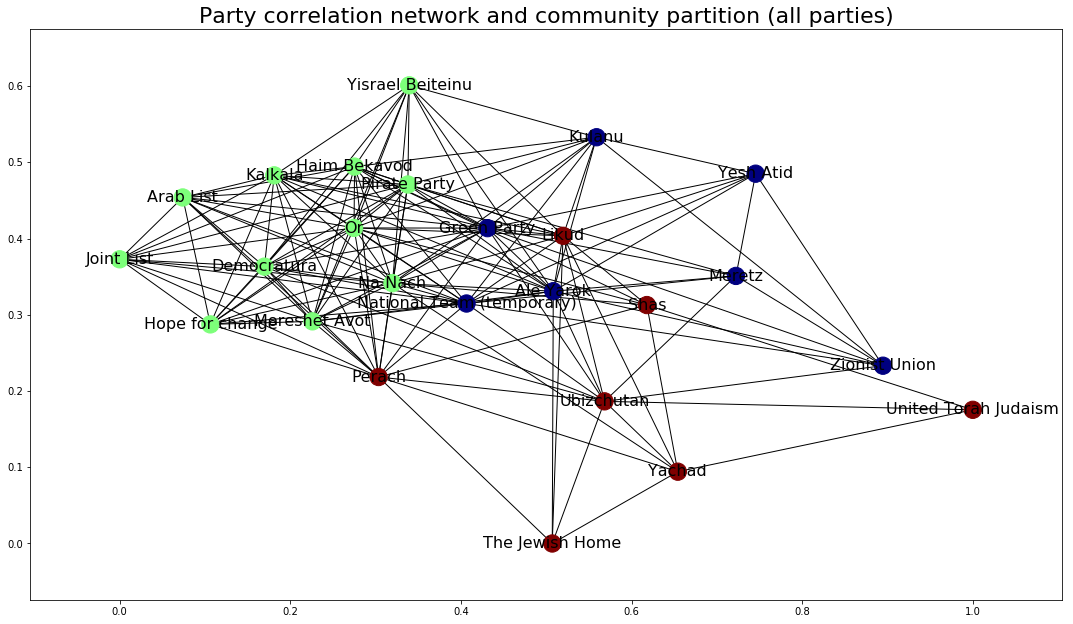

In [3]:
import networkx as nx
from community import best_partition # --> http://perso.crans.org/aynaud/communities/

C=np.corrcoef(relative_votes,rowvar=0)
A=1*(C>0)
G=nx.Graph(A)
G=nx.relabel_nodes(G,dict(zip(G.nodes(),relative_votes.columns.values)))
communities=best_partition(G)

community_colors={0:0,1:0.5,2:1}
node_coloring=[community_colors[communities[node]] for node in G.nodes()]

nx.pos=nx.fruchterman_reingold_layout(G, dim=2, k=None, pos=None, fixed=None, iterations=5000, weight='weight', scale=1.0, center=None)

nx.draw_networkx(G, cmap=plt.get_cmap('jet'), with_labels=True, node_color=node_coloring,font_size=16)
plt.title('Party correlation network and community partition (all parties)', fontsize=22)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

# Correlation between major parties
We now consider only the major parties, which recieved a significant (over 2%) of total votes, and show the correlation network between those.

/opt/conda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/opt/conda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/opt/conda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):


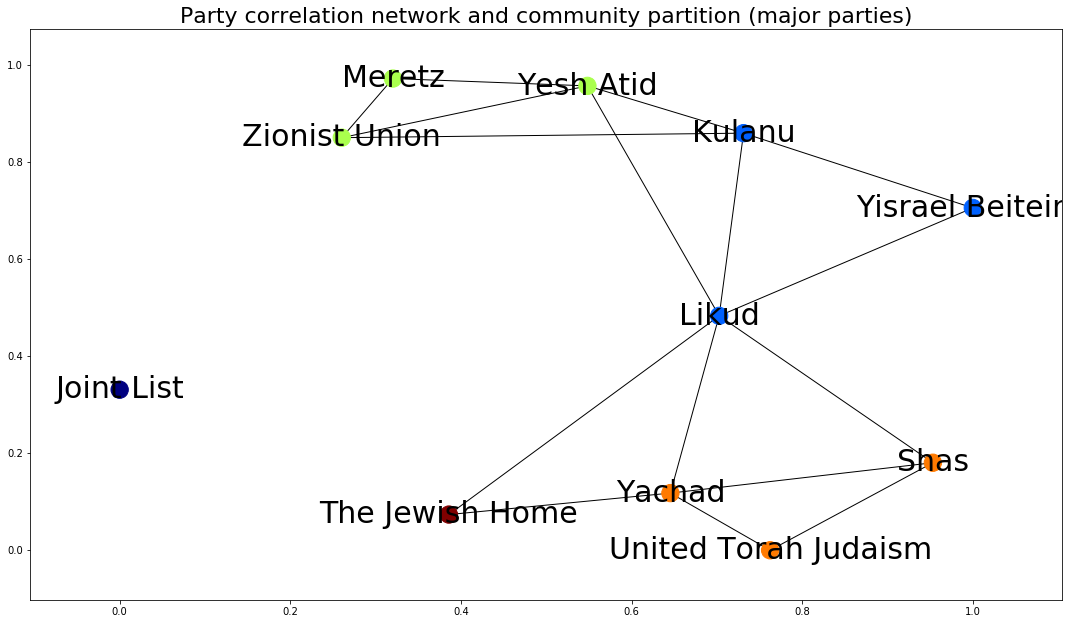

In [4]:
threshold=0.02
party_is_major=((votes.sum(axis=0)/sum(votes.sum(axis=0)))>threshold)
major_parties=relative_votes.columns.values[party_is_major==True]
major_party_votes=relative_votes[major_parties]

C=np.corrcoef(major_party_votes,rowvar=0)
A=1*(C>0)
G=nx.Graph(A)
G=nx.relabel_nodes(G,dict(zip(G.nodes(),major_parties)))
communities=best_partition(G)

community_colors={0:0,1:0.2,2:0.5,3:0.7,4:0.9}
node_coloring=[community_colors[communities[node]] for node in G.nodes()]

nx.pos=nx.fruchterman_reingold_layout(G, dim=2, k=None, pos=None, fixed=None, iterations=5000, weight='weight', scale=1.0, center=None)

nx.draw_networkx(G, cmap=plt.get_cmap('jet'), with_labels=True, node_color=node_coloring,font_size=30)
plt.title('Party correlation network and community partition (major parties)', fontsize=22)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

# The network clearly shows the Likud as the central party, with a central community of parties, distinct 'left' and 'right', and the Joint List (the Arab party) disjoint from all other major parties.